<a href="https://colab.research.google.com/github/naelmostafa/Phone-Book/blob/main/Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Input Processing

*   Imports
*   Read data_set
*   Encoding
*   Balancing Data_set (downSampling)
*   Extract features and Labels
*   spliting
*   Scaling



Imports
---

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import sklearn
from sklearn.preprocessing import StandardScaler

Read data set and assign header names
---

In [6]:
name = ["fLength", "fWidth", "fSize", "fConc", "fConc1", "fAsym", "fM3Long", "fM3Trans", "fAlpha", "fDist", "class"]
data_set = pd.read_csv("magic04.data", header=None, names=name)

Encoding categorical Labels
---
G = 0
H = 1



In [7]:
le = LabelEncoder()
data_set["class"] = le.fit_transform(data_set["class"])

Balancing Data_set
---
1.   Separate classes
2.   DownSampling to majority class

In [8]:
data_g = data_set.loc[data_set["class"] == 0]
data_h = data_set.loc[data_set["class"] == 1]

In [9]:
data_g_down = sklearn.utils.resample(data_g, replace=False, n_samples=len(data_h), random_state=123)
data_g_down.reset_index(drop=True, inplace=True)
data_h.reset_index(drop=True, inplace=True)

Get Features and Labels
---

In [10]:
features_g = data_g_down.iloc[:, :-1].values
labels_g = data_g_down.iloc[:, -1].values

features_h = data_h.iloc[:, :-1].values
labels_h = data_h.iloc[:, -1].values

Make balanced Splits from all classes
---

In [11]:
train_features_g, test_features_g, train_labels_g, test_labels_g = train_test_split(features_g, labels_g,
                                                                                    test_size=0.3,
                                                                                    random_state=42)
train_features_h, test_features_h, train_labels_h, test_labels_h = train_test_split(features_h, labels_h, test_size=0.3,
                                                                                    random_state=42)

train_features = np.concatenate([train_features_g, train_features_h])
train_labels = np.concatenate([train_labels_g, train_labels_h])

test_features = np.concatenate([test_features_g, test_features_h])
test_labels = np.concatenate([test_labels_g, test_labels_h])

Scaling Features
---

In [12]:
sc = StandardScaler()
train_features = sc.fit_transform(train_features)
test_features = sc.transform(test_features)

# Creating Models and training Function

Imports
---

In [16]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import time

Result Format and Modeling functions
---

In [17]:
def results_format(classifier_name, train_time, prediction_time, accuracy, precision, sensitivity, specificity,
                   f1_score, cm, tuning_parameter=None):
    print(classifier_name + ": ")
    print("Confusion Matrix : ")
    print(cm)
    print(f"Training time= {round(train_time, 6)} s")
    print(f"Prediction_time= {round(prediction_time, 6)} s")
    print(f"Accuracy = {accuracy}")
    print(f"Precision = {precision}")
    print(f"Sensitivity = {sensitivity}")
    print(f"Specificity = {specificity}")
    print(f"F score = {f1_score}")
    if tuning_parameter != None:
        print(f"Tuning parameter = {tuning_parameter}")
    print("-------------------------------------------------------------------------------------")

def modeling(clf, classifier_name, tuning_parameter=None):
    t1 = time.time()
    clf.fit(train_features, train_labels)
    t2 = time.time()
    train_time = t2 - t1

    t1 = time.time()
    predictions = clf.predict(test_features)
    t2 = time.time()
    prediction_time = t2 - t1

    """
    CM = | TN FP |
         | FN TP |
    """
    cm = confusion_matrix(test_labels, predictions)
    accuracy = accuracy_score(predictions, test_labels)

    # precision = (TP) / (TP + FP)
    precision = (cm[1][1]) / (cm[1][1] + cm[0][1])

    # sensitivity = (TP) / (TP + FN)
    sensitivity = (cm[1][1]) / (cm[1][1] + cm[1][0])

    # specificity = (TN) / (TN + FP)
    specificity = (cm[0][0]) / (cm[0][0] + cm[0][1])

    # f1_score = 2 * (precision * recall) / (precision + recall)
    f1_score = 2 * (precision * sensitivity) / (precision + sensitivity)

    results_format(classifier_name, train_time, prediction_time, accuracy, precision, sensitivity, specificity,
                   f1_score,
                   cm, tuning_parameter)
    
def plot_tuning_parameter(x, y, title, x_label, y_label):
   plt.title(title, fontsize='16')  # title
   plt.plot(x, y)  # plot the points
   plt.xlabel(x_label, fontsize='13')  # adds a label in the x axis
   plt.ylabel(y_label, fontsize='13')  # adds a label in the y axis
   plt.grid()  # shows a grid under the plot
   plt.show()

Decision Tree
---

In [18]:
def decision_tree():
    clf = DecisionTreeClassifier()
    modeling(clf, "Decision Tree")

Naive Bayes
---

In [19]:
def naive_bayes():
    clf = GaussianNB()
    modeling(clf, "Naive Bayes")

KNN
---

In [20]:
def get_best_k():
    k_range = range(1, 20)
    k_scores = []
    skf = StratifiedKFold(n_splits=7)
    for k in k_range:
        clf = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(clf, train_features, train_labels, cv=skf, scoring='accuracy')
        k_scores.append(scores.mean())
    plot_tuning_parameter(k_range, k_scores, "K for K-Nearest Neighbor", "K-values", "Mean-Accuracy")
    return (k_scores.index(max(k_scores))) + k_range[0]

def knn():
  k = get_best_k()
  clf = KNeighborsClassifier(n_neighbors=k)
  modeling(clf, "K-Nearest Neighbors", k)

Ada Boost
---

In [21]:
def get_best_n_estimators_ab():
    # default = 50
    n_range = range(50, 70)
    n_scores = []
    skf = StratifiedKFold(n_splits=7)
    for n in n_range:
        clf = AdaBoostClassifier(n_estimators=n)
        scores = cross_val_score(clf, train_features, train_labels, cv=skf, scoring='accuracy')
        n_scores.append(scores.mean())
    plot_tuning_parameter(n_range, n_scores, "N_Estimators for AdaBoost", "n-values", "Mean-Accuracy")
    return (n_scores.index(max(n_scores))) + n_range[0]

def ada_boost():
   estimators = get_best_n_estimators_ab()
   clf = AdaBoostClassifier(n_estimators=estimators)
   modeling(clf, "AdaBoost", estimators)
  

Random Forest
---

In [22]:
def get_best_n_estimators_rf():
    # default = 100
    n_range = range(70, 100)
    n_scores = []
    skf = StratifiedKFold(n_splits=7)
    for n in n_range:
        clf = RandomForestClassifier(n_estimators=n)
        scores = cross_val_score(clf, train_features, train_labels, cv=skf, scoring='accuracy')
        n_scores.append(scores.mean())
    plot_tuning_parameter(n_range, n_scores, "N_Estimators for Random Forest", "n-values", "Mean-Accuracy")
    return (n_scores.index(max(n_scores))) + n_range[0]

def random_forests():
    estimators = get_best_n_estimators_rf()
    clf = RandomForestClassifier(n_estimators=estimators)
    modeling(clf, "Random Forests", estimators)  

# Main

Naive Bayes: 
Confusion Matrix : 
[[1813  194]
 [1156  851]]
Training time= 0.006528 s
Prediction_time= 0.005012 s
Accuracy = 0.6636771300448431
Precision = 0.8143540669856459
Sensitivity = 0.4240159441953164
Specificity = 0.9033383158943697
F score = 0.5576671035386632
-------------------------------------------------------------------------------------


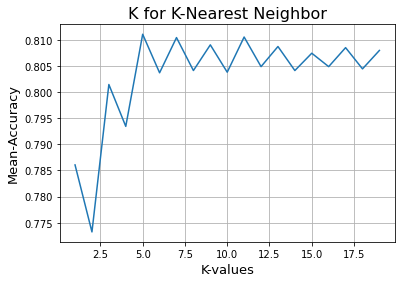

K-Nearest Neighbors: 
Confusion Matrix : 
[[1748  259]
 [ 534 1473]]
Training time= 0.019654 s
Prediction_time= 0.285663 s
Accuracy = 0.8024414549078226
Precision = 0.8504618937644342
Sensitivity = 0.7339312406576981
Specificity = 0.8709516691579472
F score = 0.7879112062048677
Tuning parameter = 5
-------------------------------------------------------------------------------------
Decision Tree: 
Confusion Matrix : 
[[1605  402]
 [ 416 1591]]
Training time= 0.157782 s
Prediction_time= 0.000945 s
Accuracy = 0.7962132536123567
Precision = 0.7982940291018565
Sensitivity = 0.7927254608868959
Specificity = 0.7997010463378177
F score = 0.7955
-------------------------------------------------------------------------------------


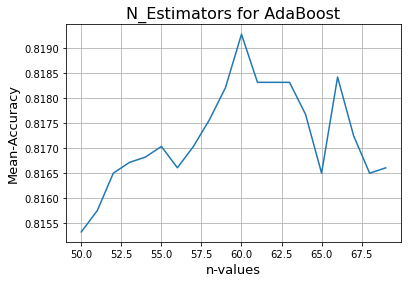

AdaBoost: 
Confusion Matrix : 
[[1651  356]
 [ 365 1642]]
Training time= 1.04494 s
Prediction_time= 0.050648 s
Accuracy = 0.8203786746387643
Precision = 0.8218218218218218
Sensitivity = 0.8181365221723966
Specificity = 0.8226208271051321
F score = 0.8199750312109864
Tuning parameter = 60
-------------------------------------------------------------------------------------


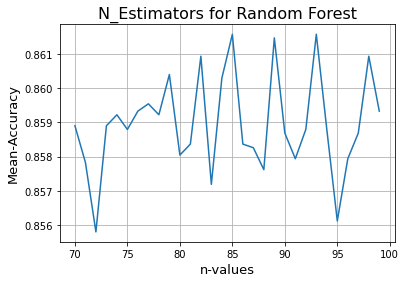

Random Forests: 
Confusion Matrix : 
[[1770  237]
 [ 329 1678]]
Training time= 2.819124 s
Prediction_time= 0.071506 s
Accuracy = 0.8589935226706528
Precision = 0.8762402088772846
Sensitivity = 0.8360737419033383
Specificity = 0.8819133034379671
F score = 0.8556858745537991
Tuning parameter = 93
-------------------------------------------------------------------------------------


In [23]:
naive_bayes()
knn()
decision_tree()
ada_boost()
random_forests()